In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as linalg
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
import array_to_latex as a2l
import seaborn as sns
import math
from matplotlib.pylab import figure, subplot, plot, xlabel, ylabel, hist, show
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate


df = pd.read_csv("../../Prostate_Cancer.csv", index_col="id")
df["diagnosis_result"] = np.where(df["diagnosis_result"] == "M", 1, 0)

continuous_cols = ['radius', 
                    'texture', 
                    'perimeter', 
                    'area', 
                    'smoothness', 
                    'compactness', 
                    'symmetry', 
                    'fractal_dimension']
                    
df_means = df[continuous_cols].mean()

df_std = df[continuous_cols].std()

df[continuous_cols] = (df[continuous_cols] -  df_means) / df_std

X = df.to_numpy() # df as a numpy array

In [2]:
# Field selected for regression:
target_column = "smoothness"

continuous_cols.remove(target_column)

y = df[target_column]
X = df[continuous_cols]

X = X.to_numpy()
y = y.to_numpy()

N, M = X.shape

In [56]:
K = 5
CV = model_selection.KFold(K, shuffle=True, random_state=230)

lambdas = np.logspace(1.2, 3, num=20)

Error_train = np.empty((K,1))
Error_train_man = np.empty((K,1))
Error_test_man = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
opt_lambdas = np.empty((K,1))
error = np.empty((K,1))

w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

In [57]:

model = lm.LinearRegression()

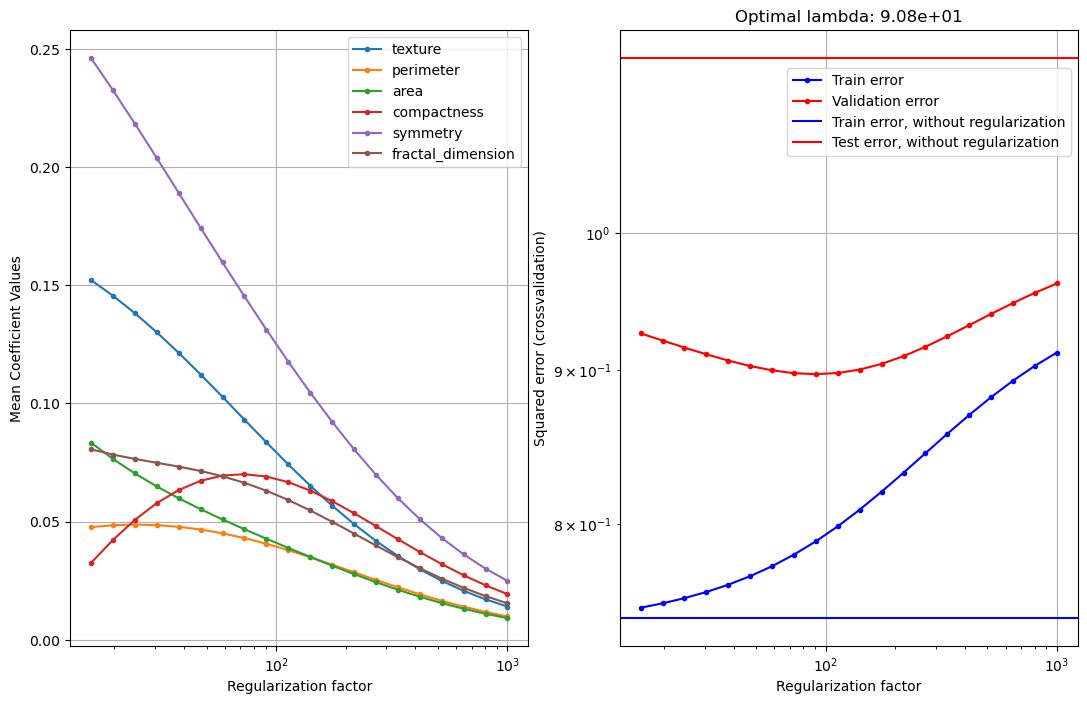

In [67]:
k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    error[k] = opt_val_err
    opt_lambdas[k] = opt_lambda
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    model.fit(X_train, y_train)
    Error_train[k] = np.square(y_train-model.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-model.predict(X_test)).sum()/y_test.shape[0]
    Error_train_man[k] = np.square(y_train-(X_train @ np.linalg.solve(XtX, Xty))).sum()/y_train.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(13,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        legend(continuous_cols[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: {0}'.format(np.format_float_scientific(opt_lambda, precision=2)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        x1 = (90, Error_train[k, 0])
        x2 = (100, Error_train[k, 0])
        plt.axline(x1, x2, color='b')
        x1 = (90, Error_test[k, 0])
        x2 = (100, Error_test[k, 0])
        plt.axline(x1, x2, color='r')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error',
                'Train error, without regularization', 'Test error, without regularization'],
                   bbox_to_anchor = [1, 0.95])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

   

In [47]:
Error_train

array([[0.62555262],
       [0.56712133],
       [0.61941732],
       [0.74567724],
       [0.74425633]])

In [48]:
Error_test

array([[1.0869689 ],
       [1.4216987 ],
       [1.19938236],
       [0.5231359 ],
       [1.14331769]])

In [7]:
opt_lambdas

array([[174.6245352 ],
       [ 30.49372829],
       [ 90.76005217],
       [ 72.97227645],
       [140.40042455]])

In [8]:
error

array([[0.93339165],
       [0.69219748],
       [0.86631977],
       [0.70983873],
       [0.93379823]])

In [9]:
Error_test_rlr

array([[0.66018833],
       [1.24681869],
       [0.72595726],
       [1.24090841],
       [0.6231609 ]])

 Just plotting how weights change in the folds (just to see something)

<Axes: >

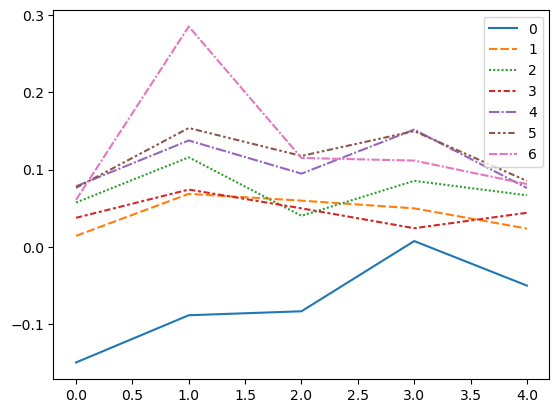

In [10]:
sns.lineplot(data=w_rlr.T)

In [11]:
Error_train_nofeatures

array([[1.00612314],
       [1.04881584],
       [0.98331911],
       [0.9061412 ],
       [0.99730123]])

In [12]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(continuous_cols[m], np.round(w_rlr[m,-1],2)))


Linear regression without feature selection:
- Training error: 0.6576616206718381
- Test error:     1.1076257516881682
- R^2 train:     0.3345796472607682
- R^2 test:     -0.14965523281735435

Regularized linear regression:
- Training error: 0.7311648141361302
- Test error:     0.899406719563807
- R^2 train:     0.2602093033253802
- R^2 test:     0.06646478740526118

Weights in last fold:
         radius           -0.05
        texture            0.02
      perimeter            0.07
           area            0.04
    compactness            0.08
       symmetry            0.09
fractal_dimension            0.08
